# Making slides with the Assistants API and DALL-E3

This notebook illustrates the use of the new [**Assistants API**](https://platform.openai.com/docs/assistants/overview) and [**DALL-E3**](https://platform.openai.com/docs/guides/images?context=node) in crafting informative and visually captivating slides. <br>
Creating engaging slides is a pivotal aspect of many jobs, but it can be a laborious and time-consuming task. Additionally, extracting insights from data and articulating them effectively on slides can be challenging. <br><br> This cookbook recipe will demonstrate how you can utilize the new Assistants API, with GPT-Vision, and DALL-E3 to facilitate the slide creation process, saving you valuable time and effort!

## 0. Setup

In [29]:
from IPython.display import display, Image
import base64
import time
from openai import OpenAI
import os
import requests
import pandas as pd
import json

client = OpenAI()

#Lets import some helper functions for assistants from https://cookbook.openai.com/examples/assistants_api_overview_python
def show_json(obj):
    display(json.loads(obj.model_dump_json()))

def submit_message(assistant_id, thread, user_message):
    client.beta.threads.messages.create(
    thread_id=thread.id, role="user", content=user_message, file_ids = file_ids
)
    return client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant_id,
)

def get_response(thread):
    return client.beta.threads.messages.list(thread_id=thread.id)


## 1. Creating the content

In this recipe, we will be creating a brief fictional presentation for the quarterly financial review of our company, NotReal Corporation. In the presentation, we want to highlight some key trends we are seeing that are affecting the profitability of our company.<br> Let's say we have the some financial data at our disposal. Let's load in the data, and take a look...

In [30]:
financial_data_path = 'data/NotRealCorp_financial_data.json'
financial_data = pd.read_json(financial_data_path)
financial_data.head(5)


,Year,Quarter,Distribution channel,Revenue ($M),Costs ($M),Customer count,Time
0,2021,Q1,Online Sales,1.50,1.301953,150,2021 Q1
1,2021,Q1,Direct Sales,1.50,1.380809,151,2021 Q1
2,2021,Q1,Retail Partners,1.50,1.348246,152,2021 Q1
3,2021,Q2,Online Sales,1.52,1.308608,152,2021 Q2
4,2021,Q2,Direct Sales,1.52,1.413305,153,2021 Q2


As you can see, this data has quarterly revenue, costs and customer data across different distribution channels. Let's create an Assistant
that can act as a personal analyst and make a nice visualization for our PowerPoint!

First, we need to upload our file so our Assistant can access it.

In [31]:
file = client.files.create(
  file=open('data/NotRealCorp_financial_data.json',"rb"),
  purpose='assistants',
)


Now, we're ready to create our Assistant. We can instruct our assistant to act as a data scientist, and take any queries we give it and run the necessary code to output the proper data visualization. We can also turn on the tool of Code Interpreter, so our Assistant will be able to code. Finally, we can specifiy any files we want to use, which in this case is just the `financial_data` file we created above.

In [32]:
assistant = client.beta.assistants.create(
  instructions="You are a data scientist assistant. When given data and a query, write the proper code and create the proper visualization",
  model="gpt-4-1106-preview",
  tools=[{"type": "code_interpreter"}],
  file_ids=[file.id]
)


Let's create a thread now, and as our first request ask the Assistant to calculate quarterly profits, and then plot the profits by distribution channel over time. We can even specify the colors of each line.

In [33]:
thread = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "content": "Calculate profit (revenue minus cost) by quarter and year, and visualize as a line plot across the distribution channels, where the colors of the lines are green, light red, and light blue",
      "file_ids": [file.id]
    }
  ]
)


No we can execute the run of our thread

In [34]:

run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
)


As the creation of a run is an asynchronous operation, let's use the helper function `wait_on_run` from
  the Assistants API Overview cookbook (https://cookbook.openai.com/examples/assistants_api_overview_python). This allows us to run the thread we have created and wait for its completion.

In [35]:
import time

def wait_on_run(run, thread):
    while run.status == "queued" or run.status == "in_progress":
        run = client.beta.threads.runs.retrieve(
            thread_id=thread.id,
            run_id=run.id,
        )
        time.sleep(0.5)
    return run


In [36]:
#This may take 1-2 mins
run = wait_on_run(run,thread)


Let's see the messages the Assistant added.

In [9]:
messages = client.beta.threads.messages.list(thread_id=thread.id)
show_json(messages)


{'data': [{'id': 'msg_BfexIYLDVQ9q7V0HHXTWl1j8',
   'assistant_id': 'asst_eh2CMQbkzuvd3IxqSTENOY57',
   'content': [{'image_file': {'file_id': 'file-EI1xQ9drwMUE9n3Vxctc2QEK'},
     'type': 'image_file'},
    {'text': {'annotations': [],
      'value': "Here is the line plot that shows the profit by quarter and year across the three distribution channels. The Online Sales are shown in green, Direct Sales in light red, and Retail Partners in light blue, with markers indicating the specific data points for each quarter-year combination.\n\nWarnings related to the `SettingWithCopyWarning` are due to how the pandas DataFrame was handled for the assignment of the 'Time' column. This is typically resolved by using the `.loc` accessor, but generally, such warnings do not affect the plot's creation nor the visual output we have here.\n\nIf there is anything more you would like to analyze or any other modifications to the plot, please let me know!"},
     'type': 'text'}],
   'created_at': 1701

We can see that the last message (latest message is shown first) from the assistant contains the image file we are looking for.  We can write a quick helper function to convert our output file to a png

In [37]:
def convert_file_to_png(file_id, write_path):
    data = client.files.content(file_id)
    data_bytes = data.read()
    with open(write_path, "wb") as file:
        file.write(data_bytes)


In [38]:
plot_file_id = messages.data[0].content[0].image_file.file_id
image_path = "data/NotRealCorp_chart.png"
convert_file_to_png(plot_file_id,image_path)


Let's load in the plot!

![Financial data plot](data/NotRealCorp_chart.png)

Nice! So, with just one sentence, we were able to have our assistant use code interpreter to
calculate the profitability, and graph the three lineplots of the various distribution channels.<br><br>
Now we have a nice visual for our slide, but we want some insights to go along with it. Let's use GPT-Vision to help us generate those.

## Generating insights

To get insights from our image, we simply need to add a new message to our thread. Our Assistant will know to use GPT-Vision, and can give us some concise takeaways from the visual provided.

In [39]:
submit_message(assistant.id,thread,"Give me two short sentences of the \
      most important insights from the plot you just created.\
             These will be used for a slide deck, and they should be about the\
                     'so what' behind the data."
)

wait_on_run(run,thread)


Run(id='run_tqSV9MoA5TKpaklvmtOyvlna', assistant_id='asst_EQXrbHwaxfVRCKsLzSO2BzyL', cancelled_at=None, completed_at=1701381206, created_at=1701381138, expires_at=None, failed_at=None, file_ids=['file-q7YEwsdGvxS7dtortXJwOSx6'], instructions='You are a data scientist assistant. When given data and a query, write the proper code and create the proper visualization', last_error=None, metadata={}, model='gpt-4-1106-preview', object='thread.run', required_action=None, started_at=1701381139, status='completed', thread_id='thread_gzIixUClfJA0AGnDnRDR8eBK', tools=[ToolAssistantToolsCode(type='code_interpreter')])

Now, once the run has completed, we can get the latest message

In [40]:
response = get_response(thread)
# Wait for a response
time.sleep(5)
bullet_points = response.data[0].content[0].text.value
print(bullet_points)


Cool! Now we have some two insights to accompany our plot. Now let's get a compelling title for the slide.

In [41]:
submit_message(assistant.id,thread,"Given the plot and bullet points you created,\
 come up with a very brief title for a slide. It should reflect just the main insights you came up with."
)
wait_on_run(run,thread)
#get the bullet points
#title = "Maximizing Returns: Navigating Seasonal Peaks and Channel Dynamics"


Run(id='run_tqSV9MoA5TKpaklvmtOyvlna', assistant_id='asst_EQXrbHwaxfVRCKsLzSO2BzyL', cancelled_at=None, completed_at=1701381206, created_at=1701381138, expires_at=None, failed_at=None, file_ids=['file-q7YEwsdGvxS7dtortXJwOSx6'], instructions='You are a data scientist assistant. When given data and a query, write the proper code and create the proper visualization', last_error=None, metadata={}, model='gpt-4-1106-preview', object='thread.run', required_action=None, started_at=1701381139, status='completed', thread_id='thread_gzIixUClfJA0AGnDnRDR8eBK', tools=[ToolAssistantToolsCode(type='code_interpreter')])

And the title is

In [15]:
response = get_response(thread)
title = response.data[0].content[0].text.value
print(title)


Given the plot and bullet points you created, come up with a very brief title for a slide. It should reflect just the main insights you came up with.


## DALL-E3 title image

Nice, now we have a title, a plot and two bullet points. We're almost ready to put this all on a slide, but as a final step, let's have DALL-E3 come up with an image to use as the title slide of the presentation. <br><br>
*Note:* DALL-E3 is not yet available within the assistants API but is coming soon! <br> <br>
We'll feed in a brief description of our company (NotRealCorp) and have DALL-E3 do the rest!

In [16]:
company_summary = "NotReal Corp is a prominent hardware company that manufactures and sells processors, graphics cards and other essential computer hardware."


In [19]:
response = client.images.generate(
  model='dall-e-3',
  prompt=f"given this company summary {company_summary}, create an inspirational \
    photo showing the growth and path forward. This will be used at a quarterly\
       financial planning meeting",
       size="1024x1024",
       quality="hd",
       n=1
)
image_url = response.data[0].url


Let's take a look at our image

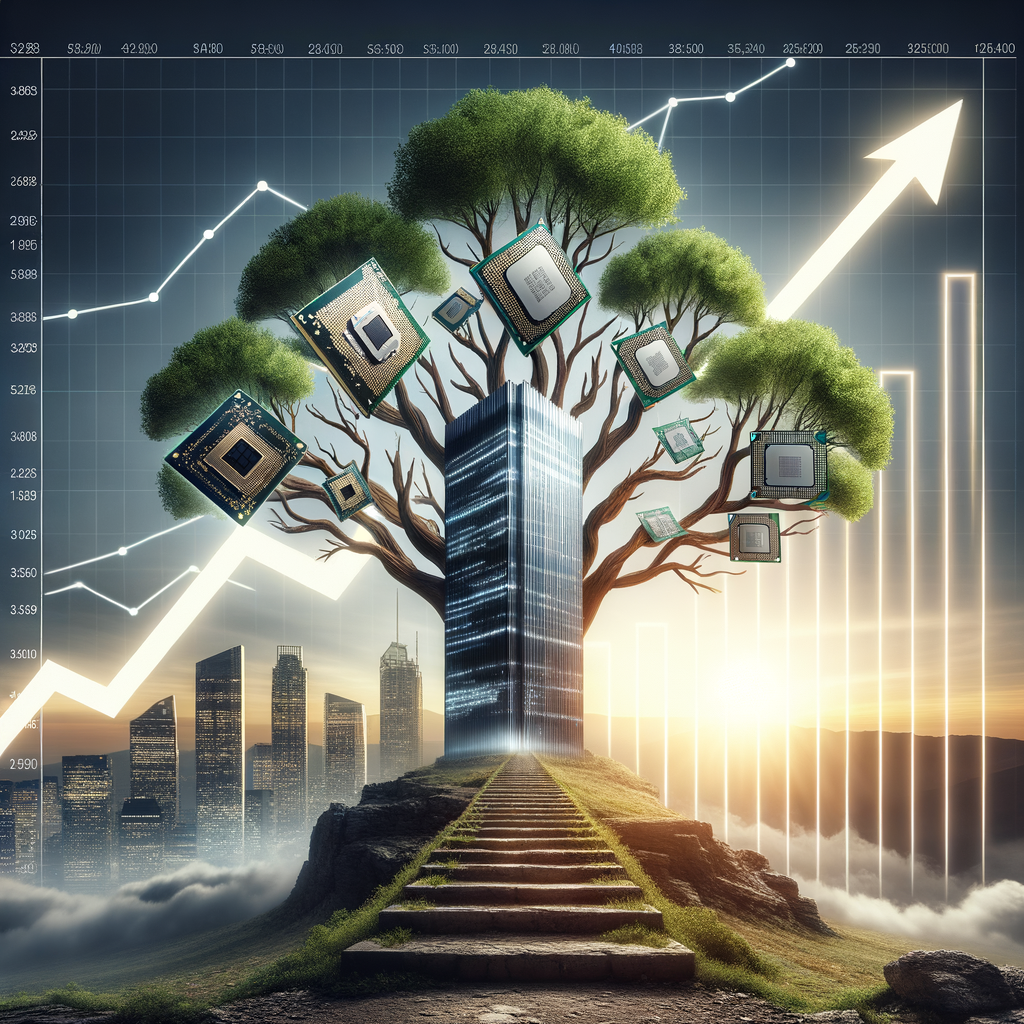

In [20]:
from PIL import Image
import requests

intro_image = Image.open(requests.get(image_url, stream=True).raw)
intro_image


Cool, now we can add this image to our thread, and ask the Assistant API to write the code to create our slide!

First, we can save the image locally, then upload it using the `File` upload endpoint.

In [25]:
dalle_img_path = 'data/dalle_image.png'
img = requests.get(image_url)

#Save locally
with open(dalle_img_path,'wb') as file:
  file.write(img.content)

#Upload
file = client.files.create(
  file=open(dalle_img_path, "rb"),
  purpose='assistants'
)


In [28]:
'file-F9PpdOfFY3AunLkJsf6Y58CF'


'file-F9PpdOfFY3AunLkJsf6Y58CF'

In [23]:
file = client.files.create(
  file=open(image_url, "rb"),
  purpose='assistants'
)


FileNotFoundError: [Errno 2] No such file or directory: 'https://oaidalleapiprodscus.blob.core.windows.net/private/org-p13k3klgno5cqxbf0q8hpgrk/user-MpnUWBP6ZgAJfz7XVhxT3YAb/img-vSXQ1h23u53wywHrIsmRdEDi.png?st=2023-11-30T20%3A27%3A55Z&se=2023-11-30T22%3A27%3A55Z&sp=r&sv=2021-08-06&sr=b&rscd=inline&rsct=image/png&skoid=6aaadede-4fb3-4698-a8f6-684d7786b067&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2023-11-30T20%3A31%3A23Z&ske=2023-12-01T20%3A31%3A23Z&sks=b&skv=2021-08-06&sig=E8syp/nxeXJY8PjNI4GAWV3s3BXqWsCtTg7xVr34ybE%3D'

## Putting it all together


Now, we can pull up Google Slides, PowerPoint, or another presentation program and simply copy our results to the page. <br>
We don't have a `seed` parameter yet in the Assistants API, so the DALL-E3 image and wordings will be different from what you see when you run this notebook, due to the non-deterministic quality of LLMs, but the outputs should be directionally the same.

For our title slide, we have

![Title slide](data/NotRealCorp_title_slide.png)

And for the data slide, we have:

![Data slide](data/NotRealCorp_data_slide.png)

Woo! We've made all the content needed for these slides with our Assistants API, GPT-4, GPT-Vision, and DALL-E3. Hopefully this helps make the slide creation process a bit easier, and provides a glimpse into how helpful the Assistants API can be!